In [1]:
cd /home/users/cdonoso/astromer/ASTROMER/

/home/users/cdonoso/astromer/ASTROMER


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os

from sklearn.metrics import precision_recall_fscore_support

from core.data import pretraining_records
from distutils.dir_util import copy_tree
import shutil
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# Something GPU-related is solved when using the following lines.
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'pretraining_records' from 'core.data' (/home/users/cdonoso/astromer/ASTROMER/core/data.py)

In [5]:
def get_prediction(data, folder):
    model = tf.keras.models.load_model(folder, custom_objects={'NormedLSTMCell':NormedLSTMCell})
    y_pred = model.predict(data)
    y_pred = tf.argmax(y_pred, 1)
    return y_pred

In [ ]:
def save_results(dataset_name, exp_path):
    num_cls = pd.read_csv(
        os.path.join('./data/records/{}/fold_0/{}_500/'.format(dataset_name, 
                                                           dataset_name), 'objects.csv')).shape[0]

    for fold_n in range(3):
        results = []
        for dataset in ['{}_20'.format(dataset_name),
                        '{}_50'.format(dataset_name), 
                        '{}_100'.format(dataset_name), 
                        '{}_500'.format(dataset_name)]:
            
            ds_path = './data/records/{}/fold_{}/{}/'.format(dataset_name, fold_n, dataset)
    #         ds_path = './data/records/{}/fold_{}/{}/'.format(dataset_name, fold_n, dataset_name)
            test_ds = pretraining_records(os.path.join(ds_path, 'test/'),
                                 1000, max_obs=200, msk_frac=0., rnd_frac=0., same_frac=0.,
                                            sampling=False, shuffle=False,
                                            n_classes=num_cls)
            y_true = np.concatenate([np.argmax(y, 1) for _, y in test_ds])
            for model_name in ['lstm', 'lstm_att', 'mlp_att']:
                path = '{}/{}/fold_{}/{}/'.format(exp_path, dataset_name, fold_n, dataset)
                try:
                    y_pred = get_prediction(test_ds, os.path.join(path, model_name, 'model'))
                except Exception as e:
                    print(e)
                    print(path)
                    continue

                prec, reca, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
                results.append([dataset, model_name, f1, prec, reca])

        df_results = pd.DataFrame(results, columns=['exp', 'model', 'f1', 'recall', 'precision'])
        df_results.to_csv('{}/{}/results_{}.csv'.format(exp_path, dataset_name, fold_n), index=False)

# Copying LSTM Baseline experiments

In [10]:
dataset_name = 'alcock'
source = './latest/freezed_astromer/{}'.format(dataset_name)
target = './latest/training_astromer/{}'.format(dataset_name)
for fold_n in range(3):
    for subset in [20, 50, 100, 500]:
        lstm_path = os.path.join(source, 'fold_{}'.format(fold_n), '{}_{}'.format(dataset_name, subset), 'lstm')
        destinity = os.path.join(target, 'fold_{}'.format(fold_n), '{}_{}'.format(dataset_name, subset), 'lstm')
        
        copy_tree(lstm_path, destinity)

# Saving Predictions

In [3]:
%%time
for ds in ['alcock']:
    for exp in ['./presentation/experiments/clf/']:
        save_results(ds, exp)

NameError: name 'save_results' is not defined

In [22]:
# save_results('alcock', './latest/freezed_astromer/big_ft/')

# Visualizing

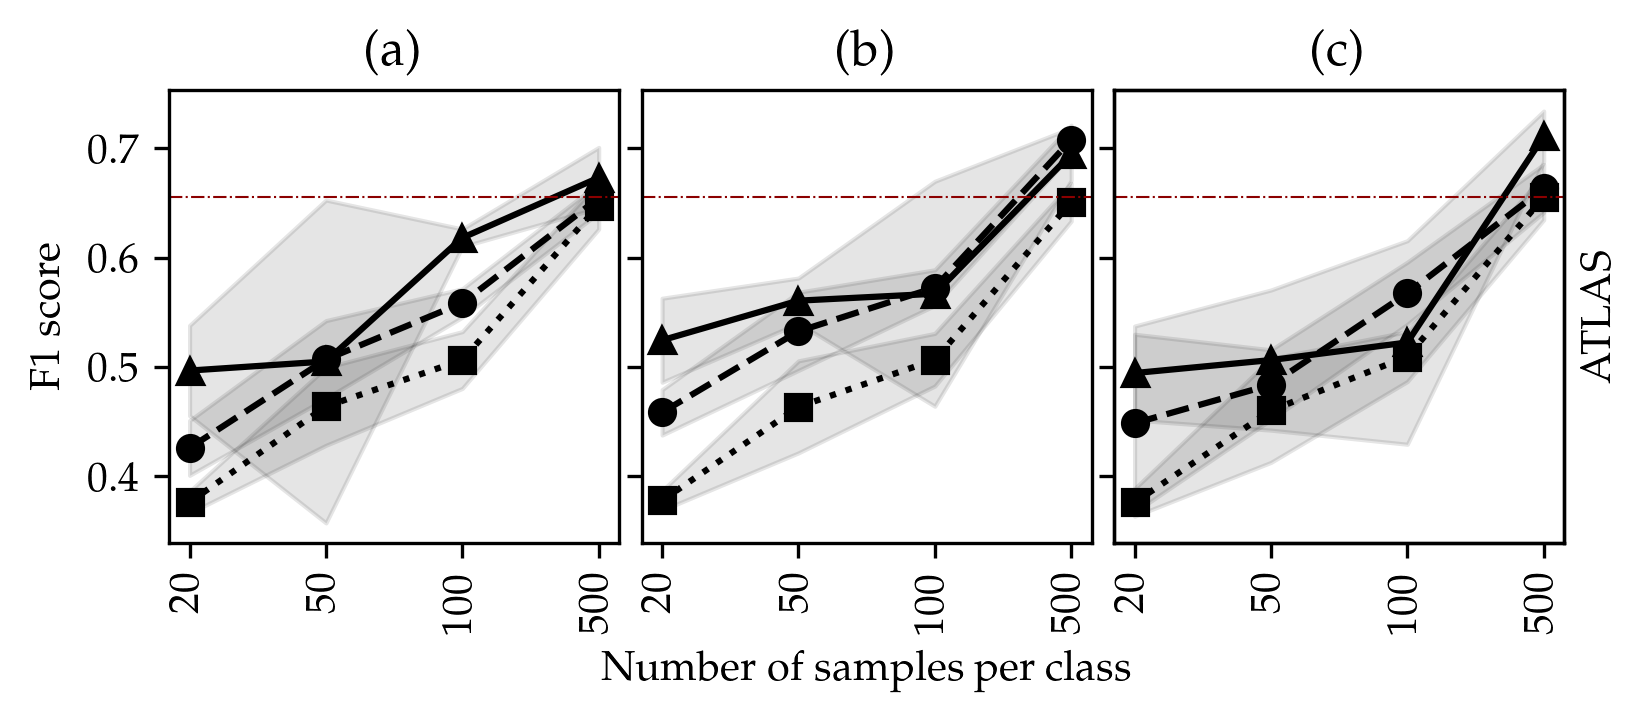

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(6,2), dpi=300, sharey=True,
                        gridspec_kw={'hspace': 0.4, 'wspace': 0.05})
dataname = 'atlas'
exps = ['./latest/freezed_astromer/', './latest/training_astromer/', './latest/training_astromer/big_ft/']
for k, exp_path in enumerate(exps):
    
    fold_0 = pd.read_csv('{}/{}/results_0.csv'.format(exp_path, dataname))
    fold_1 = pd.read_csv('{}/{}/results_1.csv'.format(exp_path, dataname))
    fold_2 = pd.read_csv('{}/{}/results_2.csv'.format(exp_path, dataname))

    for (exp0, g0), (exp1, g1), (exp2, g2), ls in zip(fold_0.groupby('model'), 
                                                      fold_1.groupby('model'), 
                                                      fold_2.groupby('model'), [['s', ':'], ['o', '--'], ['^', '-']]):


        f1_mean = np.mean([g0['f1'][:], g1['f1'][:], g2['f1'][:]], 0)
        f1_std = np.std([g0['f1'][:], g1['f1'][:], g2['f1'][:]], 0)

        xrange = range(len(g0['exp'][:]))    

        if k == 0:
            title = '(a)'  
        if k == 1:
            title = '(b)'  
        if k == 2:
            title = '(c)'  
            
        if exp0 == 'lstm':
            exp0 = 'Baseline' 
            lstm_score = f1_mean[-1]
        if exp0 == 'lstm_att':
            exp0 = 'LSTM+ATT'  
        if exp0 == 'mlp_att':
            exp0 = 'MLP+ATT'  

        axes[k].plot(xrange, f1_mean, marker=ls[0],label=exp0, linestyle=ls[1], color='k')
        axes[k].fill_between(xrange, f1_mean+f1_std, f1_mean-f1_std, alpha=0.1, color='k')
        axes[k].set_xticks(xrange)
        axes[k].set_xticklabels([x.split('_')[-1] for x in g0['exp'][:]], rotation=90)
        axes[k].set_title(title)
        
        
for i in range(3):
    axes[i].axhline(y=lstm_score, linewidth=0.5, linestyle='-.', color='darkred', label='Baseline max')
        
ax2 = axes[-1].twinx()     
ax2.set_yticks([])
if dataname == 'atlas' or dataname=='ogle':
    ax2.set_ylabel(str(dataname).upper())
        
axes[0].set_ylabel('F1 score')
# plt.ylabel('Macro F1 score')
axes[1].set_xlabel('Number of samples per class')

if dataname == 'alcock':
    ax2.set_ylabel('MACHO')
    axes[2].legend(loc='lower right', ncol=4, bbox_to_anchor=(1.25, 1.15))
    
plt.savefig('./presentation/figures/{}_clf_exp.pdf'.format(dataname), format='pdf', bbox_inches='tight')
plt.show()


# Entire dataset

In [5]:
from sklearn.metrics import accuracy_score
def save_results(dataset_name, exp_path):
    num_cls = pd.read_csv(
        os.path.join('./data/records/{}/fold_0/{}/'.format(dataset_name, 
                                                           dataset_name), 'objects.csv')).shape[0]
    results = []
    for fold_n in range(3):            
        ds_path = './data/records/{}/fold_{}/{}/'.format(dataset_name, fold_n, dataset_name)
#         ds_path = './data/records/{}/fold_{}/{}/'.format(dataset_name, fold_n, dataset_name)
        test_ds = pretraining_records(os.path.join(ds_path, 'test/'),
                             1000, max_obs=200, msk_frac=0., rnd_frac=0., same_frac=0.,
                                        sampling=False, shuffle=False,
                                        n_classes=num_cls)
    
        y_true = np.concatenate([np.argmax(y, 1) for _, y in test_ds])
        for model_name in ['lstm', 'lstm_att', 'mlp_att']:
            path = '{}/{}/fold_{}/{}/'.format(exp_path, dataset_name, fold_n, dataset_name)
            try:
                y_pred = get_prediction(test_ds, os.path.join(path, model_name, 'model'))
            except Exception as e:
                print(e)
                print(path)
                continue

            prec, reca, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            acc = accuracy_score(y_true, y_pred)
            results.append([dataset_name, model_name, f1, prec, reca, acc])
        
    df_results = pd.DataFrame(results, columns=['exp', 'model', 'f1', 'recall', 'precision', 'acc'])
    return df_results    

In [18]:
%%time
df_results = save_results('naul_macho', './latest/training_astromer/')

[INFO] Processing labels


/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-02-02 16:08:55.238304: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-02-02 16:08:55.313127: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-02-02 16:08:55.437087: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
202

[INFO] Processing labels


/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-02-02 16:11:06.937783: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-02-02 16:11:07.076231: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-02-02 16:11:07.503703: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-02-02

[INFO] Processing labels


/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-02-02 16:13:17.024987: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-02-02 16:13:17.037553: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-02-02 16:13:18.023924: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-02-02

CPU times: user 9min 27s, sys: 44.5 s, total: 10min 11s
Wall time: 6min 29s


/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
df_results

exp     model        f1    recall  precision       acc
0  naul_macho      lstm  0.503326  0.511495   0.507230  0.726058
1  naul_macho  lstm_att  0.615510  0.604664   0.638255  0.781701
2  naul_macho   mlp_att  0.545928  0.544097   0.558106  0.777379
3  naul_macho      lstm  0.505526  0.518470   0.501940  0.722885
4  naul_macho  lstm_att  0.576727  0.583526   0.584480  0.781522
5  naul_macho   mlp_att  0.547359  0.573915   0.541669  0.763016
6  naul_macho      lstm  0.490263  0.504728   0.501426  0.723984
7  naul_macho  lstm_att  0.577169  0.608890   0.590340  0.783130
8  naul_macho   mlp_att  0.535258  0.564164   0.557648  0.760888

In [21]:
for a, b in zip(df_results.groupby('model').mean().iterrows(),df_results.groupby('model').std().iterrows()):
    print('{:.3f} +- {:.3f}'.format(a[1]['acc'], b[1]['acc']))

0.724 +- 0.002
0.782 +- 0.001
0.767 +- 0.009
